# Introduction

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast, json, random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

games_dir = "steam_games.json"

These notebooks are an attempt to learn and understand recommender system design. Currently, my goals for the project  are to:
- Conduct exploratory data analysis and visualization of the Steam game library and available user preference library
- Implement content-based filtering through game recommendations and collaborative filtering through user recommendations
- Deploy both recommender systems onto a cloud service, with an accompanying frontend interface

The goal of this notebook specifically is to analyze the Steam game library and implement content-based filtering. The dataset used is a collection of Steam games, sourced from: https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data. This data is comprehensive enough to recommend with both games and other users, and is relatively free of unnecessary information and other headaches.

# Data Loading

As you can see, the games dataset includes quite a lot of games to work with:

In [ ]:
with open(games_dir) as f:
    lines = f.readlines()
f"Number of games: {len(lines)}"

'Number of games: 32135'

The format the games are stored in can be seen here:

In [ ]:
ast.literal_eval(lines[28])

{'publisher': 'Valve',
 'genres': ['Action'],
 'app_name': 'Half-Life',
 'sentiment': 'Overwhelmingly Positive',
 'title': 'Half-Life',
 'url': 'http://store.steampowered.com/app/70/HalfLife/',
 'release_date': '1998-11-08',
 'tags': ['FPS',
  'Classic',
  'Action',
  'Sci-fi',
  'Singleplayer',
  'Shooter',
  'Aliens',
  'First-Person',
  'Multiplayer',
  "1990's",
  'Story Rich',
  'Adventure',
  'Atmospheric',
  'Silent Protagonist',
  'Great Soundtrack',
  'Moddable',
  'Linear',
  'Retro',
  'Difficult',
  'Funny'],
 'reviews_url': 'http://steamcommunity.com/app/70/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player', 'Multi-player', 'Valve Anti-Cheat enabled'],
 'price': 9.99,
 'metascore': 96,
 'early_access': False,
 'id': '70',
 'developer': 'Valve'}

As this is a game developed by Valve, the developers of Steam, this has the most complete set of information in the dataset. The following are quite obviously of interest to the recommender system:
- Publisher and Developer. This will recommend games from the same or closely-related series (e.g. Half-Life 2, CSGO)
- Genre, Tags, and Specs. This will recommend games that are similar but not directly related (e.g. DOOM, Quake)
- Sentiment and Release Date. This will recommend games that are considered similar in quality or time period (e.g. Portal)

The formatting of the JSON file is a bit odd. We'll evaluate this using an Abstract Syntax Tree and store it for later to make creating a dataframe easier:

In [ ]:
data = ast.literal_eval("[" + ','.join(lines) + "]")

with open('gamesdata.json', 'w') as json_file:
    json.dump(data, json_file)

In [118]:
df = pd.read_json('gamesdata.json')
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,NaN,NaN,NaN


In [ ]:
df.shape

(32135, 16)

In only the heading of our dataframe, we can see quite a few issues with the data. We address this in the Data Cleaning section.   

# Data Cleaning

The goals of this section are to remove any bloat or empty values from the data, as well as engineer some features to be more usable. This involves simple dataframe manipulation and limited Natural Language Processing.

The first task is to identify and remove empty values. We can use pandas to check the amount of NaN values in each column, relative to the total length of our data:

In [119]:
df.replace("NaN", np.nan, inplace=True)
nan_counts = df.isna().sum()
print(nan_counts / df.shape[0])

publisher         0.250568
genres            0.102163
app_name          0.000062
title             0.063793
url               0.000000
release_date      0.064322
tags              0.005072
discount_price    0.992998
reviews_url       0.000062
specs             0.020850
price             0.042850
early_access      0.000000
id                0.000062
developer         0.102661
sentiment         0.223495
metascore         0.916695
dtype: float64


Here we can see that around 99% of games lack a discount_price feature and around 92% of games lack a metascore. Our recommender systems can't gain too much from these features, as discount_price is certainly outdated, and metascore is echoed by sentiment. We remove these first, and then remove all other NaN values. Since other features have <25% of missing value rows, this still leaves us with enough data to work with:

In [120]:
# mostly NaN columns
df.drop("metascore", axis=1, inplace=True)
df.drop("discount_price", axis=1, inplace=True)

# OPTIONAL: irrelvant columns. we can choose to remove these to make the data more elegant
df.drop("url", axis=1, inplace=True)
df.drop("reviews_url", axis=1, inplace=True)

df = df.dropna()
df.shape

(19476, 12)

Since we still have over half of our original data, we can proceed comfortably. The next step is to simplify the formatting of the string and list content so they can be tokenized. This mostly involves getting rid of unnecesary formatting so that vectorizers can count a tag, genre, etc. as a singular entity.

In [121]:
list_features = ['genres', 'tags', 'specs']

for feature in list_features:
    # remove spaces within elements
    df[feature] = df[feature].apply(lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else x)

    # turn lists into strings with spaces between elements, no other syntax
    df[feature] = df[feature].astype(str).apply(lambda x: ' '.join(ast.literal_eval(x)))

# remove spaces within strings
df['developer'] = df['developer'].apply(lambda x: x.replace(" ", ""))
df['publisher'] = df['publisher'].apply(lambda x: x.replace(" ", ""))
# remove spaces within strings, categorize sentiment with not enough reviews
df['sentiment'] = df['sentiment'].apply(lambda x: "" if "user reviews" in x else x.replace(" ", ""))

df[['genres', 'tags', 'specs', 'sentiment']].head(1)

<ipython-input-121-e3bb7c9fc8e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].apply(lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else x)


,genres,tags,specs,sentiment
1,FreetoPlay Indie RPG Strategy,FreetoPlay Strategy Indie RPG CardGame Trading...,Single-player Multi-player OnlineMulti-Player ...,MostlyPositive


One final step is to transform our date data, currently presented as MM/DD/YYYY. While the year a game was released could tell us a lot, information about the month and day are mostly irrelevant and could even confuse our model into false comparisons. To that end, we convert our release_date content to only include years:

In [7]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date'] = df['release_date'].dt.year.astype(str)

df[['title', 'release_date']].head(3)

ValueError: time data "Soon.." doesn't match format "%Y-%m-%d", at position 10. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

That concludes Data Cleaning. Since the data was already well-maintained, there wasn't much needed to do. The next steps would be to explore and visualize the data further, then implement our filtering algorithm.

# EDA

Now that we have clean data, we should analyze and visualize it. This will help us learn more about the domain and possibly influence decisions on how to model it. Note that since this is mostly categorical data, the types of graphs we can use are limited.

Here's a spread of the most commmon developers and publishers in our data:

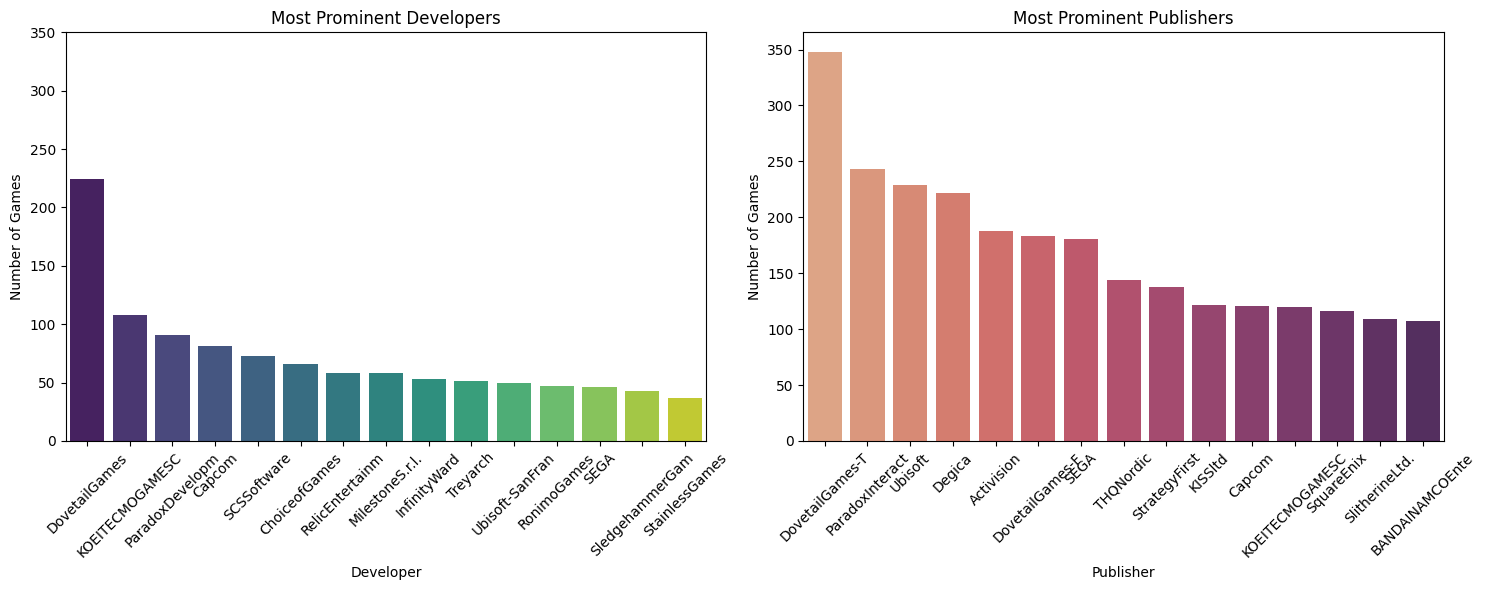

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

developer_counts = df['developer'].value_counts().head(15)
publisher_counts = df['publisher'].value_counts().head(15)

# plotting developer bar chart using Seaborn
sns.barplot(x=developer_counts.index, y=developer_counts, ax=ax1, palette='viridis')
ax1.set_title('Most Prominent Developers')
ax1.set_xlabel('Developer')
ax1.set_ylabel('Number of Games')
ax1.tick_params(axis='x', rotation=45)  # adjust rotation for better visibility
ax1.set_xticklabels([label[:15] for label in developer_counts.index])  # limiting entry length
ax1.set_ylim(0, 350)  # set y-axis range for ax1

# plotting publisher bar chart using seaborn
sns.barplot(x=publisher_counts.index, y=publisher_counts, ax=ax2, palette='flare')
ax2.set_title('Most Prominent Publishers')
ax2.set_xlabel('Publisher')
ax2.set_ylabel('Number of Games')
ax2.tick_params(axis='x', rotation=45)  # adjust rotation for better visibility
ax2.set_xticklabels([label[:15] for label in publisher_counts.index])  # limiting entry length
ax1.set_ylim(0, 350)  # set y-axis range for ax1

plt.tight_layout()
plt.show()

Here, we can see that usually publishers publish more games than developers develop games, indicating that there are more developers than publishers. There are some notable companies that appear in both lists, namely SEGA and Capcom. However, we can also see developers owned by certain publishers, such as Activision owning InfinityWard and Treyarch. Overall, it seems as though there's enough difference between the two features to consider both features in our recommendations.

One choice we have to make is whether or not to include sentiment. Sentiment is a label generated by Steam to summarize the reviews of a product. These have a reputation for being unreliable, and so I've visualized how they relate with publisher, a metric that we know we can use and that is generally considered more reliable. This is shown through a heatmap, with lighter values indicating a higher number of products within that category:

<ipython-input-165-eb115af8f919>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['sentiment'] = pd.Categorical(df_top_10['sentiment'], categories=sentiment_order, ordered=True)


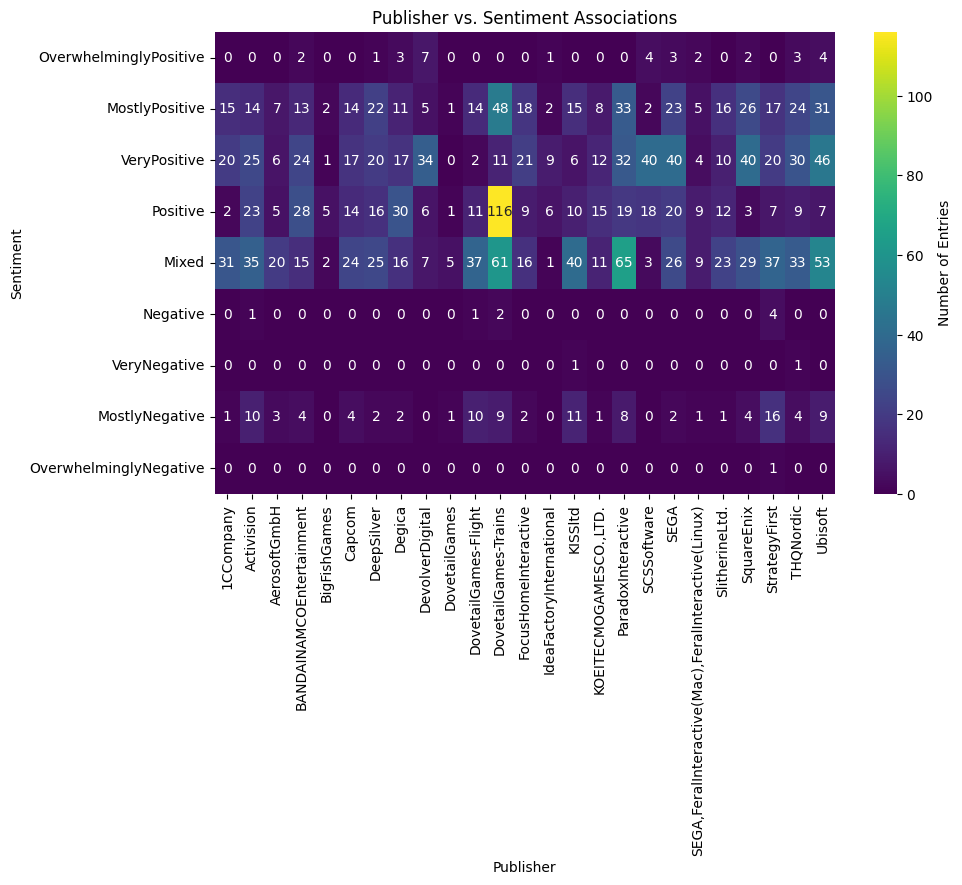

In [165]:
# get a dataframe with the top 25 publishers and available sentiments
top_publishers = df['publisher'].value_counts().head(25).index
df_filtered_sentiment = df[df['sentiment'] != ''] # filter empty (not enough users) rows with no sentiment
top_sentiments = df_filtered_sentiment['sentiment'].value_counts().index
df_top = df[(df['publisher'].isin(top_publishers)) & (df['sentiment'].isin(top_sentiments))]

# manually reorder the rows based on the custom order for sentiments
sentiment_order = ['OverwhelminglyPositive', 'MostlyPositive', 'VeryPositive', 'Positive', 'Mixed',
                   'Negative', 'VeryNegative', 'MostlyNegative', 'OverwhelminglyNegative']

df_top_10['sentiment'] = pd.Categorical(df_top_10['sentiment'], categories=sentiment_order, ordered=True)
df_top_10 = df_top_10.sort_values(by='sentiment')

# create a pivot table of sentiment and publisher counts to be visualized
heatmap_data = df_top_10.groupby(['sentiment', 'publisher']).size().unstack(fill_value=0)

# create heatmap from pivot table
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='g', cbar_kws={'label': 'Number of Entries'})
plt.title('Publisher vs. Sentiment Associations')
plt.xlabel('Publisher')
plt.ylabel('Sentiment')
plt.show()

We can see here that there doesn't seem to be any correlation between the two features. Publishers aren't organized in any way but there are notably more pravelent publishers, such as the ones that appeared in a previous visualization, that have similar scores as unknown publishers. Furthermore, regardless of publisher, the vast majority games seem to fit inbetween MostlyPositive and Mixed. This overall lack of variation seems to indicate that we shouldn't use it in our analysis.

Games are often grouped in "generations" that define and group trends in game design. Let's look at release years on Steam:

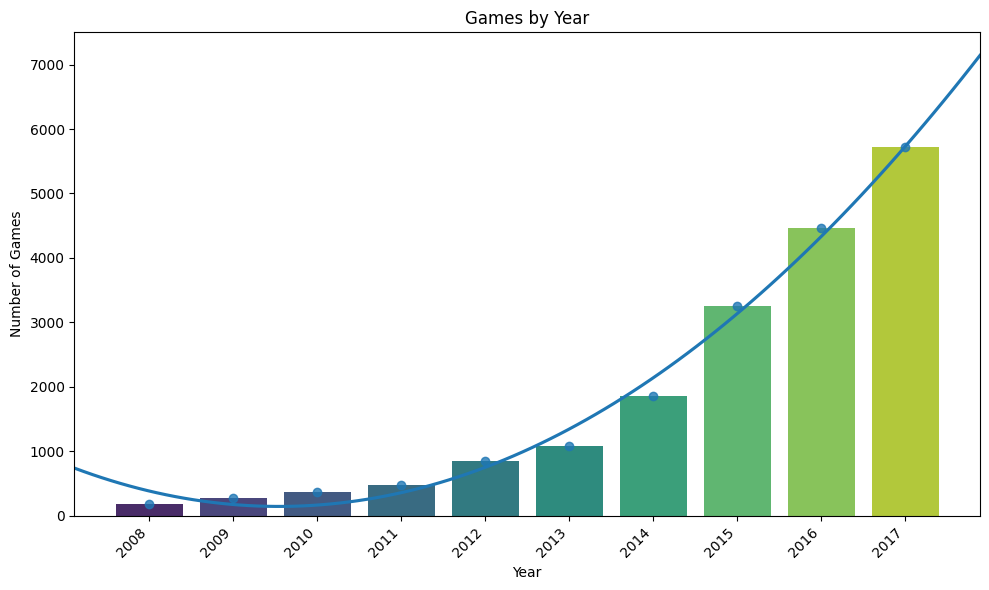

In [226]:
# count occurrences of each release year
filtered_df = df[(df['release_date'].astype(int) <= 2000000)]
year_counts = filtered_df['release_date'].value_counts().head(10)
sorted_year_counts = year_counts.sort_index()

# plotting the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sorted_year_counts.index, y=sorted_year_counts.values, palette='viridis')

# regression plot to show likely value for past 2017
sns.regplot(x=np.arange(len(sorted_year_counts)), y=sorted_year_counts.values, ci=None, truncate=False, order=2)

plt.title('Games by Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better visibility
plt.tight_layout()
plt.show()

We can firstly see that there aren't too many years in our dataset. It starts at 2008, the year of Steam's creation. I've also removed the years past 2017 as the dataset was created around that year. This is fine for most games, but it may confuse our recommendation system when trying to recommend games such as remakes or rereleases that come from before 2008. There is also far more games in recent years than before, which may lead to the system prioritizing older games since they're more rare. While not too relevant to our system, I've also fitted a regression line so we can see and predict how Steam has grown over time. This trend, according to SteamDB, has roughly continued until now but experienced a decline from 2019-2020, as one would expect: https://steamdb.info/stats/releases/

Finally, we need to consider whether names should be used. As stated before, it's fairly obvious to include genre, so let's compare how tokens appear between the two using a word cloud, a representation of the most common words in our data:

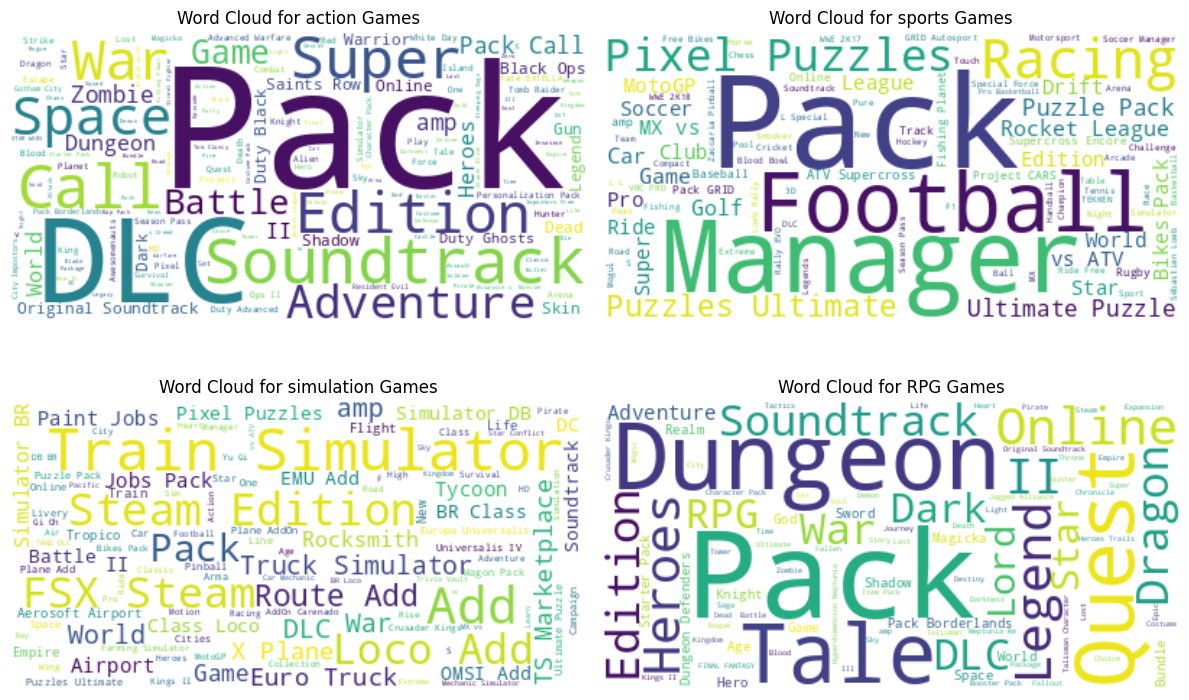

In [108]:
genres_to_plot = ['action', 'sports', 'simulation', 'RPG']

# create a subplot grid based on the number of genres
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten() # flatten for iteration

for i, genre in enumerate(genres_to_plot):
    # filter df for rows where 'genre' matches the desired genre and 'locale_synopsis' is not None
    genre_df = df[df['genres'].str.contains(genre, case=False, na=False)]

    # add all titles together and create wordcloud
    text = ' '.join(list(genre_df['title']))
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)

    # plot wordcloud on axes[i]
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Word Cloud for {genre} Games')

plt.tight_layout()
plt.show()

Looking at how the two correlate, it seems like we can "predict" key terms based on their genre. RPG games heavily include words like "Dungeon" and "Adventure" whereas Action games often include "War" and "Super." However, all word clouds generated seem to have filler or irrelevant terms to our task such as "Pack" and "Steam." Since we've already found an association with genre, we can disregard the names.

This concludes the analysis. We've found several features that we should focus on, as well as several features to disregard, so we are safe to move towards modeling and deployment.

# Content-Based Modeling

The first (and simpler) approach to recommending games we'll use is Content-Based Filtering. This simply finds items similar to a given item. Similarity is judged using vectorization and a cosine similarity matrix which uses item features, such as genre or developer, and then the most similar items are recommended to a user. While not as detailed as Collaborative Filtering, this solution doesn't require access to user data and is simpler to implement.

The process of "vectorization" is to convert information into numerical representations, or embeddings. This allows us to then find cosine similarities, and therefore recommendations, later on. The first step is to identify what information we want to embed. To that end, we combine all of the information we want into a singular string. Since we tokenized our information into lists and strings already, this is very easy:

In [166]:
def soup(x):
    return ''.join(x['publisher']) + ' ' + ''.join(x['developer']) + ' ' + ''.join(x['release_date']) + ' ' + ''.join(x['genres']) + ' ' + ''.join(x['tags']) + ' ' + ''.join(x['specs'])

df['soup'] = df.apply(soup, axis=1)
df['soup'].head(5)

1     MakingFun,Inc. SecretLevelSRL 2018 FreetoPlay ...
2     Poolians.com Poolians.com 2017 Casual FreetoPl...
5     TrickjumpGamesLtd TrickjumpGamesLtd 2018 Actio...
15    Apillo Apillo 2018 Adventure Casual Indie Simu...
21    TeroLunkka TeroLunkka 2018 Action Adventure In...
Name: soup, dtype: object

As seen above, we have summarized what we have identified as the most important data into a singular string. Note that there are clearly repeats. For example, on item 2 we can see the developer and publisher being the same, and thus being present in the string twice. This will also often occur with tags and genres often being similar. This is intentionally done so that we can use the frequency of certain terms to identify further similarities between items.

The CountVectorizer class is initalized here in order to create embeddings from our features. As we can see in the final matrix's shape, this creates the same number of rows but with far more features:

In [167]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])
count_matrix.shape

(19476, 11725)

Before we can finally make recommendations, we create a cosine similarity matrix. This takes our count_matrix and finds the similarities between each entry of the matrix.. Note that this creates an extremely large matrix that should be created on a cloud service:

In [168]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim.shape

(19476, 19476)

Now that we have the cosine_similarity matrix, getting recommendations is as easy as sorting for the highest similarities in the matrix to our desired item:

In [202]:
def get_recommendations(title, df, cosine_sim):
    df = df.reset_index()
    indices = pd.Series(df.index, index=df['title'])

    # get index of the games that matches the title
    idx = indices[title]

    # get sorted pairwise similarity scores of all games with that game
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the scores of the 15 most similar games
    sim_scores = sim_scores[1:16]
    # pick random 10 to give unique response
    sim_scores = random.sample(sim_scores, 10)

    # get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # return the top 10 most similar games
    return df[['title', 'soup']].iloc[movie_indices]

get_recommendations("Team Fortress 2", df, cosine_sim)

,title,soup
18768,BRINK,BethesdaSoftworks SplashDamage 2011 Action Fre...
18925,Day of Defeat: Source,Valve Valve 2010 Action FPS WorldWarII Multipl...
19467,Day of Defeat,Valve Valve 2003 Action FPS WorldWarII Multipl...
1797,Warface,My.com Crytek 2014 Action FreetoPlay Massively...
19457,Team Fortress Classic,Valve Valve 1999 Action Action FPS Multiplayer...
19220,Left 4 Dead,Valve Valve 2008 Action Zombies Co-op FPS Acti...
4205,Battleborn,2K GearboxSoftware 2016 Action FPS Action Mult...
858,Counter-Strike: Global Offensive,Valve Valve 2012 Action FPS Multiplayer Shoote...
19159,Killing Floor,TripwireInteractive TripwireInteractive 2009 A...
19402,Counter-Strike: Source,Valve Valve 2004 Action Action FPS Multiplayer...


Here, we can see recommendations for Valve's classic game Team Fortress 2. As expected, the recommendations make sense for the parameters we identified and used in our word soup:
- Publisher and Developer: Other Valve games and Team Fortress-related properties are recommended.
- Tags, Genre, and Specs: Other multiplayer games and shooters are recommended.
- Sentiment: Other games with similar ratings to Team Fortress 2 (OverwhelminglyPositive) are recommended.

That concludes Content-based Filtering. The next steps are to implement Collaborative Filtering and deploy the both onto a cloud provider.